In [1]:
# This is the implementation of the EncDec-AD model based on the paper "LSTM-based Encoder-Decoder for Multi-sensor Anomaly Detection". And a slight variantion "TimeNet" based on the paper "TimeNet: Pre-trained deep recurrent neural network for time series classiﬁcation", which has been shown that achives better performance in the time series anomaly detection scenario. The only difference is the second model feeds constants to its decoder as input.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [3]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = LSTMCell(hidden_num)
            self._dec_cell = LSTMCell(hidden_num)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [4]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [5]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt"

In [6]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [7]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

In [8]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=False)

# Training

iter 1: 0.15388
iter 2: 0.114866
iter 3: 0.113565
iter 4: 0.0407314
iter 5: 0.0456441
iter 6: 0.105883
iter 7: 0.0563128
iter 8: 0.0435439
iter 9: 0.0416959
iter 10: 0.05084
iter 11: 0.0523665
iter 12: 0.0548705
iter 13: 0.0503817
iter 14: 0.0498581
iter 15: 0.0666337
iter 16: 0.0469524
iter 17: 0.0477052
iter 18: 0.0442565
iter 19: 0.0474123
iter 20: 0.0465956
iter 21: 0.0448079
iter 22: 0.0394455
iter 23: 0.0407065
iter 24: 0.0448473
iter 25: 0.0426903
iter 26: 0.0472963
iter 27: 0.0465436
iter 28: 0.0464604
iter 29: 0.0463251
iter 30: 0.0481896
iter 31: 0.0453143
iter 32: 0.0463658
iter 33: 0.0453746
iter 34: 0.0439122
iter 35: 0.0442864
iter 36: 0.0462657
iter 37: 0.0427045
iter 38: 0.0554548
iter 39: 0.0503808
iter 40: 0.044759
iter 41: 0.0389932
iter 42: 0.0455794
iter 43: 0.0419719
iter 44: 0.0475893
iter 45: 0.0423595
iter 46: 0.0479723
iter 47: 0.0444269
iter 48: 0.0462885
iter 49: 0.0444422
iter 50: 0.0446239
iter 51: 0.0483382
iter 52: 0.0412919
iter 53: 0.0429275
iter 54: 0

iter 421: 0.0317289
iter 422: 0.0379822
iter 423: 0.0324945
iter 424: 0.0346381
iter 425: 0.0398942
iter 426: 0.034702
iter 427: 0.0375998
iter 428: 0.0323053
iter 429: 0.0298067
iter 430: 0.033686
iter 431: 0.033705
iter 432: 0.0328742
iter 433: 0.0347034
iter 434: 0.0325697
iter 435: 0.0285951
iter 436: 0.0282896
iter 437: 0.0295892
iter 438: 0.0354683
iter 439: 0.0352879
iter 440: 0.0385001
iter 441: 0.0358941
iter 442: 0.0334191
iter 443: 0.0359714
iter 444: 0.0388985
iter 445: 0.0372455
iter 446: 0.0333427
iter 447: 0.034117
iter 448: 0.0338444
iter 449: 0.0372627
iter 450: 0.0302496
iter 451: 0.0354274
iter 452: 0.0421701
iter 453: 0.0349196
iter 454: 0.0378793
iter 455: 0.0413784
iter 456: 0.0349285
iter 457: 0.0392844
iter 458: 0.0407947
iter 459: 0.0338151
iter 460: 0.0368351
iter 461: 0.034554
iter 462: 0.039531
iter 463: 0.034839
iter 464: 0.0439505
iter 465: 0.0435562
iter 466: 0.029626
iter 467: 0.0383721
iter 468: 0.0354891
iter 469: 0.0300087
iter 470: 0.0342095
iter 471

iter 834: 0.0368504
iter 835: 0.0316152
iter 836: 0.0333881
iter 837: 0.0294576
iter 838: 0.031091
iter 839: 0.0331333
iter 840: 0.0349335
iter 841: 0.0329659
iter 842: 0.0367429
iter 843: 0.0359666
iter 844: 0.0375599
iter 845: 0.0357937
iter 846: 0.0324246
iter 847: 0.03788
iter 848: 0.0326937
iter 849: 0.0315738
iter 850: 0.0325487
iter 851: 0.0340563
iter 852: 0.0302127
iter 853: 0.0338776
iter 854: 0.0346797
iter 855: 0.0295195
iter 856: 0.0272416
iter 857: 0.0302495
iter 858: 0.039997
iter 859: 0.0368802
iter 860: 0.034194
iter 861: 0.0327679
iter 862: 0.0351045
iter 863: 0.0307002
iter 864: 0.0322449
iter 865: 0.0382187
iter 866: 0.0356552
iter 867: 0.0308335
iter 868: 0.0357744
iter 869: 0.0308325
iter 870: 0.0353351
iter 871: 0.0418757
iter 872: 0.0347887
iter 873: 0.0351391
iter 874: 0.0336795
iter 875: 0.034903
iter 876: 0.040543
iter 877: 0.0344907
iter 878: 0.0323582
iter 879: 0.0342108
iter 880: 0.0331593
iter 881: 0.0346748
iter 882: 0.0339535
iter 883: 0.0365143
iter 88

iter 1234: 0.0347803
iter 1235: 0.0416864
iter 1236: 0.0329571
iter 1237: 0.0331333
iter 1238: 0.0306175
iter 1239: 0.034425
iter 1240: 0.0371768
iter 1241: 0.0320695
iter 1242: 0.0339224
iter 1243: 0.0333014
iter 1244: 0.0342844
iter 1245: 0.0315641
iter 1246: 0.0349814
iter 1247: 0.0344446
iter 1248: 0.0379591
iter 1249: 0.0366123
iter 1250: 0.0378463
iter 1251: 0.0290298
iter 1252: 0.0362585
iter 1253: 0.0294762
iter 1254: 0.0293139
iter 1255: 0.0338498
iter 1256: 0.0348646
iter 1257: 0.031485
iter 1258: 0.0357675
iter 1259: 0.0325886
iter 1260: 0.0313153
iter 1261: 0.0423734
iter 1262: 0.0312586
iter 1263: 0.0334712
iter 1264: 0.0360831
iter 1265: 0.0355508
iter 1266: 0.0362388
iter 1267: 0.0360558
iter 1268: 0.0360685
iter 1269: 0.0322386
iter 1270: 0.0371272
iter 1271: 0.0343419
iter 1272: 0.0292823
iter 1273: 0.0381672
iter 1274: 0.0332418
iter 1275: 0.0335868
iter 1276: 0.0293847
iter 1277: 0.0336902
iter 1278: 0.0320577
iter 1279: 0.0346778
iter 1280: 0.0343912
iter 1281: 0.03

iter 1627: 0.0333256
iter 1628: 0.0292424
iter 1629: 0.0362262
iter 1630: 0.0330839
iter 1631: 0.0333488
iter 1632: 0.0276289
iter 1633: 0.0349521
iter 1634: 0.0321337
iter 1635: 0.0381161
iter 1636: 0.0297476
iter 1637: 0.0288653
iter 1638: 0.0302256
iter 1639: 0.0360421
iter 1640: 0.0334977
iter 1641: 0.0382148
iter 1642: 0.0341385
iter 1643: 0.0337524
iter 1644: 0.0295196
iter 1645: 0.0396687
iter 1646: 0.0325741
iter 1647: 0.0368784
iter 1648: 0.0362357
iter 1649: 0.0364861
iter 1650: 0.0355493
iter 1651: 0.0373099
iter 1652: 0.0293797
iter 1653: 0.0381788
iter 1654: 0.0377317
iter 1655: 0.0251198
iter 1656: 0.0334689
iter 1657: 0.0321754
iter 1658: 0.0357774
iter 1659: 0.0380618
iter 1660: 0.0354002
iter 1661: 0.0334001
iter 1662: 0.0305784
iter 1663: 0.0321583
iter 1664: 0.034505
iter 1665: 0.0351574
iter 1666: 0.0327814
iter 1667: 0.0326638
iter 1668: 0.0335281
iter 1669: 0.0381763
iter 1670: 0.033888
iter 1671: 0.0316408
iter 1672: 0.0317219
iter 1673: 0.0334774
iter 1674: 0.03

iter 2019: 0.0340161
iter 2020: 0.0318054
iter 2021: 0.0338621
iter 2022: 0.0331582
iter 2023: 0.0314799
iter 2024: 0.0344906
iter 2025: 0.0392506
iter 2026: 0.0347946
iter 2027: 0.0380915
iter 2028: 0.0343342
iter 2029: 0.0288622
iter 2030: 0.0375008
iter 2031: 0.0347739
iter 2032: 0.0359459
iter 2033: 0.0327944
iter 2034: 0.0368165
iter 2035: 0.0311712
iter 2036: 0.0333807
iter 2037: 0.0321337
iter 2038: 0.0398415
iter 2039: 0.0338748
iter 2040: 0.0286626
iter 2041: 0.0298491
iter 2042: 0.0360304
iter 2043: 0.0388767
iter 2044: 0.036003
iter 2045: 0.0271725
iter 2046: 0.0388679
iter 2047: 0.0309095
iter 2048: 0.03517
iter 2049: 0.0302519
iter 2050: 0.0304027
iter 2051: 0.0338875
iter 2052: 0.0344614
iter 2053: 0.0318776
iter 2054: 0.0341605
iter 2055: 0.0304106
iter 2056: 0.0374378
iter 2057: 0.0356669
iter 2058: 0.0336229
iter 2059: 0.0323336
iter 2060: 0.037007
iter 2061: 0.0355956
iter 2062: 0.0298873
iter 2063: 0.0368005
iter 2064: 0.0380366
iter 2065: 0.032206
iter 2066: 0.03541

iter 2411: 0.0364371
iter 2412: 0.0384536
iter 2413: 0.0290064
iter 2414: 0.0326882
iter 2415: 0.0361923
iter 2416: 0.0323327
iter 2417: 0.0345677
iter 2418: 0.0290207
iter 2419: 0.0339176
iter 2420: 0.0369453
iter 2421: 0.0353908
iter 2422: 0.0375182
iter 2423: 0.037238
iter 2424: 0.0335089
iter 2425: 0.0430753
iter 2426: 0.0305976
iter 2427: 0.0347771
iter 2428: 0.0382881
iter 2429: 0.032918
iter 2430: 0.0382512
iter 2431: 0.0340787
iter 2432: 0.0392435
iter 2433: 0.0306878
iter 2434: 0.0351773
iter 2435: 0.0311201
iter 2436: 0.0422196
iter 2437: 0.0342478
iter 2438: 0.0316003
iter 2439: 0.0297397
iter 2440: 0.0322205
iter 2441: 0.0320021
iter 2442: 0.0278189
iter 2443: 0.0372285
iter 2444: 0.0288259
iter 2445: 0.0329788
iter 2446: 0.029849
iter 2447: 0.0332163
iter 2448: 0.0343351
iter 2449: 0.0408602
iter 2450: 0.0328841
iter 2451: 0.0354947
iter 2452: 0.0285281
iter 2453: 0.0288626
iter 2454: 0.0289797
iter 2455: 0.032327
iter 2456: 0.0288729
iter 2457: 0.0278702
iter 2458: 0.0251

iter 2803: 0.0271705
iter 2804: 0.0274526
iter 2805: 0.0323011
iter 2806: 0.031674
iter 2807: 0.0290591
iter 2808: 0.0242964
iter 2809: 0.0333146
iter 2810: 0.0297399
iter 2811: 0.029776
iter 2812: 0.0246735
iter 2813: 0.0250979
iter 2814: 0.0277734
iter 2815: 0.0272096
iter 2816: 0.0312571
iter 2817: 0.0254415
iter 2818: 0.0309284
iter 2819: 0.0294114
iter 2820: 0.0229031
iter 2821: 0.0258775
iter 2822: 0.0276559
iter 2823: 0.0328734
iter 2824: 0.026232
iter 2825: 0.0274039
iter 2826: 0.0342776
iter 2827: 0.0235075
iter 2828: 0.0267966
iter 2829: 0.026305
iter 2830: 0.0301579
iter 2831: 0.0266677
iter 2832: 0.0253507
iter 2833: 0.0266883
iter 2834: 0.0287445
iter 2835: 0.0256665
iter 2836: 0.0292939
iter 2837: 0.0265696
iter 2838: 0.0254434
iter 2839: 0.0259171
iter 2840: 0.0317433
iter 2841: 0.0220793
iter 2842: 0.0281499
iter 2843: 0.0275856
iter 2844: 0.0227281
iter 2845: 0.0255032
iter 2846: 0.0266701
iter 2847: 0.0299388
iter 2848: 0.0301704
iter 2849: 0.0272546
iter 2850: 0.0269

iter 3193: 0.0140251
iter 3194: 0.00781999
iter 3195: 0.00737401
iter 3196: 0.0112179
iter 3197: 0.0119391
iter 3198: 0.00920068
iter 3199: 0.00878872
iter 3200: 0.0108793
iter 3201: 0.00796139
iter 3202: 0.00699259
iter 3203: 0.00843894
iter 3204: 0.0128286
iter 3205: 0.00855388
iter 3206: 0.00801344
iter 3207: 0.0125031
iter 3208: 0.00735733
iter 3209: 0.0137462
iter 3210: 0.0146727
iter 3211: 0.00757343
iter 3212: 0.0121979
iter 3213: 0.0102058
iter 3214: 0.0128849
iter 3215: 0.00814924
iter 3216: 0.00698775
iter 3217: 0.0108823
iter 3218: 0.00814932
iter 3219: 0.00970515
iter 3220: 0.00906656
iter 3221: 0.0206811
iter 3222: 0.0110158
iter 3223: 0.00688514
iter 3224: 0.00873837
iter 3225: 0.0235999
iter 3226: 0.0130941
iter 3227: 0.0118276
iter 3228: 0.015749
iter 3229: 0.0150384
iter 3230: 0.0102226
iter 3231: 0.0123418
iter 3232: 0.0102962
iter 3233: 0.0107961
iter 3234: 0.00848756
iter 3235: 0.00999405
iter 3236: 0.0110572
iter 3237: 0.00836222
iter 3238: 0.0101664
iter 3239: 0.0

iter 3574: 0.00941846
iter 3575: 0.00729091
iter 3576: 0.00917391
iter 3577: 0.00658823
iter 3578: 0.00819696
iter 3579: 0.00714082
iter 3580: 0.00819069
iter 3581: 0.00833682
iter 3582: 0.00823541
iter 3583: 0.00722684
iter 3584: 0.008849
iter 3585: 0.00927063
iter 3586: 0.00867981
iter 3587: 0.00731174
iter 3588: 0.00974115
iter 3589: 0.00833193
iter 3590: 0.00781595
iter 3591: 0.00696438
iter 3592: 0.00826572
iter 3593: 0.00820817
iter 3594: 0.00606258
iter 3595: 0.0084417
iter 3596: 0.00971085
iter 3597: 0.00774071
iter 3598: 0.00738957
iter 3599: 0.00834557
iter 3600: 0.00775307
iter 3601: 0.00719097
iter 3602: 0.00665888
iter 3603: 0.00749865
iter 3604: 0.0089225
iter 3605: 0.00606047
iter 3606: 0.0061694
iter 3607: 0.0107893
iter 3608: 0.00587752
iter 3609: 0.0082868
iter 3610: 0.00651564
iter 3611: 0.00771326
iter 3612: 0.00745807
iter 3613: 0.00625984
iter 3614: 0.00710793
iter 3615: 0.00779291
iter 3616: 0.00785811
iter 3617: 0.0071999
iter 3618: 0.00842739
iter 3619: 0.00738

iter 3949: 0.00701597
iter 3950: 0.00706702
iter 3951: 0.00550861
iter 3952: 0.00828862
iter 3953: 0.00525843
iter 3954: 0.00598225
iter 3955: 0.0058594
iter 3956: 0.00664407
iter 3957: 0.00571507
iter 3958: 0.00885584
iter 3959: 0.00832831
iter 3960: 0.00724371
iter 3961: 0.00773564
iter 3962: 0.00682054
iter 3963: 0.00726714
iter 3964: 0.0062322
iter 3965: 0.00679806
iter 3966: 0.00692975
iter 3967: 0.00601744
iter 3968: 0.0065051
iter 3969: 0.00623198
iter 3970: 0.00598842
iter 3971: 0.0077473
iter 3972: 0.00629003
iter 3973: 0.0080085
iter 3974: 0.00690019
iter 3975: 0.00712114
iter 3976: 0.00650309
iter 3977: 0.00665978
iter 3978: 0.00791975
iter 3979: 0.00674326
iter 3980: 0.00806188
iter 3981: 0.0075785
iter 3982: 0.00640381
iter 3983: 0.00624094
iter 3984: 0.00636679
iter 3985: 0.00823085
iter 3986: 0.00790989
iter 3987: 0.00603398
iter 3988: 0.00594532
iter 3989: 0.00676039
iter 3990: 0.00604119
iter 3991: 0.00664966
iter 3992: 0.00550793
iter 3993: 0.00747778
iter 3994: 0.006

iter 4325: 0.00600713
iter 4326: 0.00669211
iter 4327: 0.00829582
iter 4328: 0.00572661
iter 4329: 0.00538509
iter 4330: 0.00655547
iter 4331: 0.00572101
iter 4332: 0.0087103
iter 4333: 0.00613451
iter 4334: 0.00696928
iter 4335: 0.00595324
iter 4336: 0.00715355
iter 4337: 0.00687289
iter 4338: 0.00594467
iter 4339: 0.00600363
iter 4340: 0.00595691
iter 4341: 0.0076817
iter 4342: 0.00671451
iter 4343: 0.00565814
iter 4344: 0.00605681
iter 4345: 0.00699509
iter 4346: 0.00597333
iter 4347: 0.00640315
iter 4348: 0.00722063
iter 4349: 0.0077868
iter 4350: 0.00526632
iter 4351: 0.00716095
iter 4352: 0.005394
iter 4353: 0.00568612
iter 4354: 0.00653142
iter 4355: 0.00941804
iter 4356: 0.00596311
iter 4357: 0.00684582
iter 4358: 0.00763561
iter 4359: 0.00746172
iter 4360: 0.0064565
iter 4361: 0.00629229
iter 4362: 0.00788848
iter 4363: 0.00678385
iter 4364: 0.00635729
iter 4365: 0.00614724
iter 4366: 0.004999
iter 4367: 0.00843511
iter 4368: 0.0061512
iter 4369: 0.00830764
iter 4370: 0.010302

iter 4701: 0.0062717
iter 4702: 0.00530288
iter 4703: 0.0056961
iter 4704: 0.00605467
iter 4705: 0.00558991
iter 4706: 0.00606716
iter 4707: 0.00597266
iter 4708: 0.00604764
iter 4709: 0.00605341
iter 4710: 0.00753379
iter 4711: 0.00527185
iter 4712: 0.00580788
iter 4713: 0.00612546
iter 4714: 0.00556524
iter 4715: 0.00689546
iter 4716: 0.00612932
iter 4717: 0.0064365
iter 4718: 0.00536091
iter 4719: 0.00504478
iter 4720: 0.0049858
iter 4721: 0.00594865
iter 4722: 0.00470701
iter 4723: 0.0061729
iter 4724: 0.00470523
iter 4725: 0.0054866
iter 4726: 0.00561291
iter 4727: 0.00480538
iter 4728: 0.00646089
iter 4729: 0.00542954
iter 4730: 0.00572354
iter 4731: 0.00626059
iter 4732: 0.00578864
iter 4733: 0.00587525
iter 4734: 0.00420125
iter 4735: 0.00698482
iter 4736: 0.00490102
iter 4737: 0.0050964
iter 4738: 0.0064524
iter 4739: 0.00487557
iter 4740: 0.00549962
iter 4741: 0.0056821
iter 4742: 0.00636202
iter 4743: 0.00520231
iter 4744: 0.00514499
iter 4745: 0.00455187
iter 4746: 0.005885

iter 5076: 0.00391137
iter 5077: 0.00445348
iter 5078: 0.00494707
iter 5079: 0.00425605
iter 5080: 0.00442636
iter 5081: 0.00522915
iter 5082: 0.00353597
iter 5083: 0.00361036
iter 5084: 0.00471332
iter 5085: 0.00451271
iter 5086: 0.00385882
iter 5087: 0.00489002
iter 5088: 0.00602836
iter 5089: 0.00542222
iter 5090: 0.00525209
iter 5091: 0.00427867
iter 5092: 0.00560274
iter 5093: 0.00681973
iter 5094: 0.00599649
iter 5095: 0.00514964
iter 5096: 0.00439218
iter 5097: 0.00545638
iter 5098: 0.00552011
iter 5099: 0.00380459
iter 5100: 0.00450977
iter 5101: 0.00587376
iter 5102: 0.00590693
iter 5103: 0.00572843
iter 5104: 0.00418978
iter 5105: 0.00610716
iter 5106: 0.00499371
iter 5107: 0.00363767
iter 5108: 0.00502062
iter 5109: 0.00521835
iter 5110: 0.00401186
iter 5111: 0.00550524
iter 5112: 0.00533613
iter 5113: 0.00593033
iter 5114: 0.00468006
iter 5115: 0.00384004
iter 5116: 0.00479929
iter 5117: 0.0063077
iter 5118: 0.00394032
iter 5119: 0.00427196
iter 5120: 0.0040127
iter 5121: 0

iter 5452: 0.00383473
iter 5453: 0.00519664
iter 5454: 0.00368824
iter 5455: 0.00597162
iter 5456: 0.00401527
iter 5457: 0.00378511
iter 5458: 0.00493315
iter 5459: 0.00363645
iter 5460: 0.00354826
iter 5461: 0.00497513
iter 5462: 0.00381512
iter 5463: 0.00393548
iter 5464: 0.00372951
iter 5465: 0.00307825
iter 5466: 0.0047429
iter 5467: 0.0032283
iter 5468: 0.00416308
iter 5469: 0.00407302
iter 5470: 0.004071
iter 5471: 0.00320072
iter 5472: 0.00409315
iter 5473: 0.00542977
iter 5474: 0.00309613
iter 5475: 0.00421749
iter 5476: 0.00435346
iter 5477: 0.00532887
iter 5478: 0.00395936
iter 5479: 0.00457646
iter 5480: 0.00332503
iter 5481: 0.00403793
iter 5482: 0.00322661
iter 5483: 0.00314183
iter 5484: 0.00465387
iter 5485: 0.00422115
iter 5486: 0.00406357
iter 5487: 0.00450525
iter 5488: 0.00368582
iter 5489: 0.0034383
iter 5490: 0.00394173
iter 5491: 0.00606855
iter 5492: 0.00442153
iter 5493: 0.00521878
iter 5494: 0.00369879
iter 5495: 0.0043357
iter 5496: 0.00402098
iter 5497: 0.003

iter 5828: 0.00385878
iter 5829: 0.00330222
iter 5830: 0.00336058
iter 5831: 0.00354046
iter 5832: 0.00299598
iter 5833: 0.00310176
iter 5834: 0.00443307
iter 5835: 0.00354214
iter 5836: 0.00300796
iter 5837: 0.00360942
iter 5838: 0.00407268
iter 5839: 0.00423516
iter 5840: 0.00256208
iter 5841: 0.00390277
iter 5842: 0.00384062
iter 5843: 0.00355223
iter 5844: 0.00387939
iter 5845: 0.00432526
iter 5846: 0.00452914
iter 5847: 0.00316049
iter 5848: 0.00400855
iter 5849: 0.0041974
iter 5850: 0.00393928
iter 5851: 0.00410667
iter 5852: 0.00258817
iter 5853: 0.00469682
iter 5854: 0.00322238
iter 5855: 0.00344193
iter 5856: 0.00415485
iter 5857: 0.00344152
iter 5858: 0.00414986
iter 5859: 0.00450734
iter 5860: 0.00378626
iter 5861: 0.00496355
iter 5862: 0.00369316
iter 5863: 0.00446221
iter 5864: 0.00363479
iter 5865: 0.00343808
iter 5866: 0.00318029
iter 5867: 0.00427256
iter 5868: 0.00336917
iter 5869: 0.00480605
iter 5870: 0.00350966
iter 5871: 0.0034872
iter 5872: 0.00409828
iter 5873: 0

iter 6203: 0.00456797
iter 6204: 0.00342143
iter 6205: 0.00381491
iter 6206: 0.00391703
iter 6207: 0.00336177
iter 6208: 0.00378557
iter 6209: 0.00315662
iter 6210: 0.00332402
iter 6211: 0.00286392
iter 6212: 0.00310684
iter 6213: 0.00377898
iter 6214: 0.00429295
iter 6215: 0.00351522
iter 6216: 0.00417163
iter 6217: 0.00305598
iter 6218: 0.0036201
iter 6219: 0.0033447
iter 6220: 0.00334507
iter 6221: 0.00311429
iter 6222: 0.00361427
iter 6223: 0.00253683
iter 6224: 0.00396459
iter 6225: 0.00300143
iter 6226: 0.00357155
iter 6227: 0.00328953
iter 6228: 0.00261258
iter 6229: 0.00327194
iter 6230: 0.00376105
iter 6231: 0.00297006
iter 6232: 0.00320973
iter 6233: 0.00277616
iter 6234: 0.00326601
iter 6235: 0.00355848
iter 6236: 0.00309427
iter 6237: 0.00411436
iter 6238: 0.00295347
iter 6239: 0.00301528
iter 6240: 0.00297127
iter 6241: 0.00283925
iter 6242: 0.00387006
iter 6243: 0.00394091
iter 6244: 0.00309034
iter 6245: 0.00479103
iter 6246: 0.00460729
iter 6247: 0.00327496
iter 6248: 0

iter 6579: 0.00382766
iter 6580: 0.00511503
iter 6581: 0.00550218
iter 6582: 0.00442754
iter 6583: 0.00333963
iter 6584: 0.00450415
iter 6585: 0.00467918
iter 6586: 0.00521007
iter 6587: 0.00367935
iter 6588: 0.00483677
iter 6589: 0.00624997
iter 6590: 0.00420244
iter 6591: 0.00252575
iter 6592: 0.00573016
iter 6593: 0.00441853
iter 6594: 0.00279362
iter 6595: 0.00339965
iter 6596: 0.00324382
iter 6597: 0.003313
iter 6598: 0.00361794
iter 6599: 0.00259093
iter 6600: 0.00353168
iter 6601: 0.00322394
iter 6602: 0.00349407
iter 6603: 0.00375241
iter 6604: 0.0036891
iter 6605: 0.00311408
iter 6606: 0.00328483
iter 6607: 0.00466003
iter 6608: 0.00328006
iter 6609: 0.00303852
iter 6610: 0.00324537
iter 6611: 0.00399528
iter 6612: 0.00350417
iter 6613: 0.00327551
iter 6614: 0.00348077
iter 6615: 0.00480256
iter 6616: 0.00278909
iter 6617: 0.00294594
iter 6618: 0.00468006
iter 6619: 0.00317236
iter 6620: 0.00324069
iter 6621: 0.00444794
iter 6622: 0.00332924
iter 6623: 0.00378673
iter 6624: 0.

iter 6954: 0.00424537
iter 6955: 0.00467329
iter 6956: 0.00489848
iter 6957: 0.00364204
iter 6958: 0.00321305
iter 6959: 0.00336536
iter 6960: 0.00364763
iter 6961: 0.00457798
iter 6962: 0.00352804
iter 6963: 0.00328096
iter 6964: 0.00379205
iter 6965: 0.00373704
iter 6966: 0.00361729
iter 6967: 0.00355403
iter 6968: 0.0033084
iter 6969: 0.00316238
iter 6970: 0.0041405
iter 6971: 0.00359459
iter 6972: 0.00366377
iter 6973: 0.00381063
iter 6974: 0.00432591
iter 6975: 0.00373679
iter 6976: 0.00377343
iter 6977: 0.00306949
iter 6978: 0.00409818
iter 6979: 0.0027703
iter 6980: 0.00349438
iter 6981: 0.003575
iter 6982: 0.00330507
iter 6983: 0.00337526
iter 6984: 0.00315316
iter 6985: 0.00326089
iter 6986: 0.00304505
iter 6987: 0.00360478
iter 6988: 0.00326006
iter 6989: 0.00293961
iter 6990: 0.00422983
iter 6991: 0.00325468
iter 6992: 0.00295423
iter 6993: 0.00266057
iter 6994: 0.0037421
iter 6995: 0.00398703
iter 6996: 0.00339857
iter 6997: 0.00324636
iter 6998: 0.00271612
iter 6999: 0.002

iter 7330: 0.003738
iter 7331: 0.00302075
iter 7332: 0.00363192
iter 7333: 0.0020573
iter 7334: 0.00302222
iter 7335: 0.00292272
iter 7336: 0.00311259
iter 7337: 0.00286931
iter 7338: 0.00352881
iter 7339: 0.0036904
iter 7340: 0.00273956
iter 7341: 0.00292372
iter 7342: 0.002643
iter 7343: 0.00297662
iter 7344: 0.00329509
iter 7345: 0.00318542
iter 7346: 0.00294278
iter 7347: 0.00358939
iter 7348: 0.0028452
iter 7349: 0.00284137
iter 7350: 0.00262404
iter 7351: 0.00338909
iter 7352: 0.00368576
iter 7353: 0.00289279
iter 7354: 0.00396162
iter 7355: 0.00330838
iter 7356: 0.00244109
iter 7357: 0.00269858
iter 7358: 0.00363805
iter 7359: 0.0032781
iter 7360: 0.00296864
iter 7361: 0.00253138
iter 7362: 0.00225677
iter 7363: 0.00422418
iter 7364: 0.00331057
iter 7365: 0.00362207
iter 7366: 0.00291085
iter 7367: 0.00412709
iter 7368: 0.00341319
iter 7369: 0.00400158
iter 7370: 0.00357319
iter 7371: 0.00242852
iter 7372: 0.00284659
iter 7373: 0.00280601
iter 7374: 0.00400286
iter 7375: 0.00238

iter 7707: 0.00382044
iter 7708: 0.0052883
iter 7709: 0.00502927
iter 7710: 0.00333106
iter 7711: 0.0046513
iter 7712: 0.00288995
iter 7713: 0.00442482
iter 7714: 0.00303998
iter 7715: 0.00261644
iter 7716: 0.00334024
iter 7717: 0.00375096
iter 7718: 0.00308508
iter 7719: 0.0037031
iter 7720: 0.00339028
iter 7721: 0.00303805
iter 7722: 0.00275898
iter 7723: 0.00300019
iter 7724: 0.00275575
iter 7725: 0.00368846
iter 7726: 0.00253556
iter 7727: 0.00315726
iter 7728: 0.00312212
iter 7729: 0.00294902
iter 7730: 0.0039276
iter 7731: 0.00313171
iter 7732: 0.00408981
iter 7733: 0.00364452
iter 7734: 0.00360477
iter 7735: 0.00402536
iter 7736: 0.0032322
iter 7737: 0.00286529
iter 7738: 0.00359343
iter 7739: 0.00292136
iter 7740: 0.0027341
iter 7741: 0.00391739
iter 7742: 0.00312818
iter 7743: 0.00316162
iter 7744: 0.00436894
iter 7745: 0.00316284
iter 7746: 0.00258496
iter 7747: 0.00392309
iter 7748: 0.00246417
iter 7749: 0.0033443
iter 7750: 0.00333822
iter 7751: 0.00461073
iter 7752: 0.0031

iter 8082: 0.00318988
iter 8083: 0.00264051
iter 8084: 0.00346282
iter 8085: 0.0032919
iter 8086: 0.00257319
iter 8087: 0.00294331
iter 8088: 0.00439218
iter 8089: 0.00379316
iter 8090: 0.00358886
iter 8091: 0.00410813
iter 8092: 0.00358656
iter 8093: 0.00398283
iter 8094: 0.00340809
iter 8095: 0.0034641
iter 8096: 0.00398186
iter 8097: 0.0040795
iter 8098: 0.00428324
iter 8099: 0.00378184
iter 8100: 0.00389792
iter 8101: 0.00286692
iter 8102: 0.00345707
iter 8103: 0.00319782
iter 8104: 0.00289951
iter 8105: 0.00299491
iter 8106: 0.00297506
iter 8107: 0.00330562
iter 8108: 0.00327112
iter 8109: 0.00275255
iter 8110: 0.00433122
iter 8111: 0.00246593
iter 8112: 0.00475781
iter 8113: 0.00271686
iter 8114: 0.00301856
iter 8115: 0.00415302
iter 8116: 0.00333761
iter 8117: 0.00420794
iter 8118: 0.00302218
iter 8119: 0.00274464
iter 8120: 0.00339281
iter 8121: 0.00376872
iter 8122: 0.00376625
iter 8123: 0.00422688
iter 8124: 0.00361408
iter 8125: 0.00354787
iter 8126: 0.0035623
iter 8127: 0.0

iter 8458: 0.00319497
iter 8459: 0.00329272
iter 8460: 0.00362037
iter 8461: 0.0033891
iter 8462: 0.00285126
iter 8463: 0.00342281
iter 8464: 0.0037186
iter 8465: 0.00261681
iter 8466: 0.00394965
iter 8467: 0.00291592
iter 8468: 0.003748
iter 8469: 0.00284248
iter 8470: 0.00332365
iter 8471: 0.00383822
iter 8472: 0.00284755
iter 8473: 0.00336087
iter 8474: 0.00274705
iter 8475: 0.00322278
iter 8476: 0.00255179
iter 8477: 0.00282261
iter 8478: 0.00222643
iter 8479: 0.00273095
iter 8480: 0.00316816
iter 8481: 0.00306901
iter 8482: 0.00304377
iter 8483: 0.00299418
iter 8484: 0.00237678
iter 8485: 0.00226085
iter 8486: 0.00313114
iter 8487: 0.00417401
iter 8488: 0.00288884
iter 8489: 0.00269527
iter 8490: 0.0034647
iter 8491: 0.00271484
iter 8492: 0.00214218
iter 8493: 0.00298181
iter 8494: 0.00328975
iter 8495: 0.00366129
iter 8496: 0.00350184
iter 8497: 0.00401179
iter 8498: 0.00298133
iter 8499: 0.00308863
iter 8500: 0.0036587
iter 8501: 0.00311924
iter 8502: 0.00350397
iter 8503: 0.003

iter 8833: 0.00244987
iter 8834: 0.00290206
iter 8835: 0.00246544
iter 8836: 0.00330624
iter 8837: 0.00292494
iter 8838: 0.00271618
iter 8839: 0.00266717
iter 8840: 0.00359674
iter 8841: 0.00332166
iter 8842: 0.00245243
iter 8843: 0.00388605
iter 8844: 0.00277152
iter 8845: 0.00306512
iter 8846: 0.00298182
iter 8847: 0.00286585
iter 8848: 0.0029123
iter 8849: 0.00349098
iter 8850: 0.00193803
iter 8851: 0.00260882
iter 8852: 0.00369167
iter 8853: 0.00245393
iter 8854: 0.00276749
iter 8855: 0.00340658
iter 8856: 0.00260844
iter 8857: 0.00347554
iter 8858: 0.00285685
iter 8859: 0.0026237
iter 8860: 0.002573
iter 8861: 0.00337789
iter 8862: 0.00244639
iter 8863: 0.00330754
iter 8864: 0.00313208
iter 8865: 0.00276791
iter 8866: 0.00364488
iter 8867: 0.00297251
iter 8868: 0.00297792
iter 8869: 0.00246404
iter 8870: 0.00301981
iter 8871: 0.00320477
iter 8872: 0.00394104
iter 8873: 0.00213791
iter 8874: 0.00325884
iter 8875: 0.0039658
iter 8876: 0.00327289
iter 8877: 0.00274222
iter 8878: 0.00

iter 9209: 0.00337903
iter 9210: 0.00297163
iter 9211: 0.00336071
iter 9212: 0.00308724
iter 9213: 0.00289273
iter 9214: 0.00335293
iter 9215: 0.00290031
iter 9216: 0.00275314
iter 9217: 0.00258659
iter 9218: 0.00331584
iter 9219: 0.00305027
iter 9220: 0.00233391
iter 9221: 0.00303432
iter 9222: 0.00240494
iter 9223: 0.00255753
iter 9224: 0.00312822
iter 9225: 0.00364259
iter 9226: 0.00274065
iter 9227: 0.00224602
iter 9228: 0.00247557
iter 9229: 0.00314315
iter 9230: 0.00243903
iter 9231: 0.0029007
iter 9232: 0.00270244
iter 9233: 0.00318535
iter 9234: 0.00243254
iter 9235: 0.00329896
iter 9236: 0.00250944
iter 9237: 0.00260061
iter 9238: 0.00302166
iter 9239: 0.00326782
iter 9240: 0.00254076
iter 9241: 0.00305114
iter 9242: 0.00323857
iter 9243: 0.00235534
iter 9244: 0.00321046
iter 9245: 0.00297806
iter 9246: 0.00269527
iter 9247: 0.00337416
iter 9248: 0.00287132
iter 9249: 0.0035223
iter 9250: 0.00260194
iter 9251: 0.00331981
iter 9252: 0.00303371
iter 9253: 0.00241724
iter 9254: 0

iter 9584: 0.00338919
iter 9585: 0.0023537
iter 9586: 0.00379679
iter 9587: 0.00296168
iter 9588: 0.00356822
iter 9589: 0.00312869
iter 9590: 0.00331803
iter 9591: 0.00358288
iter 9592: 0.00238839
iter 9593: 0.00298219
iter 9594: 0.00236027
iter 9595: 0.00320735
iter 9596: 0.00309267
iter 9597: 0.00334957
iter 9598: 0.0026456
iter 9599: 0.00250984
iter 9600: 0.0020278
iter 9601: 0.00245825
iter 9602: 0.00257933
iter 9603: 0.0027362
iter 9604: 0.00306488
iter 9605: 0.00295314
iter 9606: 0.00412849
iter 9607: 0.00286207
iter 9608: 0.00256646
iter 9609: 0.00249174
iter 9610: 0.00244548
iter 9611: 0.00284013
iter 9612: 0.00287754
iter 9613: 0.00263226
iter 9614: 0.00267411
iter 9615: 0.00293197
iter 9616: 0.00321869
iter 9617: 0.00310607
iter 9618: 0.00342456
iter 9619: 0.00256964
iter 9620: 0.00291405
iter 9621: 0.00249443
iter 9622: 0.00341468
iter 9623: 0.00336464
iter 9624: 0.0031245
iter 9625: 0.00302432
iter 9626: 0.00319725
iter 9627: 0.00287543
iter 9628: 0.00235412
iter 9629: 0.00

iter 9962: 0.00243809
iter 9963: 0.00255888
iter 9964: 0.0024775
iter 9965: 0.00252289
iter 9966: 0.00261622
iter 9967: 0.00329946
iter 9968: 0.00338982
iter 9969: 0.00305372
iter 9970: 0.00307575
iter 9971: 0.00291116
iter 9972: 0.00374561
iter 9973: 0.00270794
iter 9974: 0.00500346
iter 9975: 0.00378162
iter 9976: 0.00299135
iter 9977: 0.00404473
iter 9978: 0.00353985
iter 9979: 0.00429248
iter 9980: 0.00388353
iter 9981: 0.00356944
iter 9982: 0.00387043
iter 9983: 0.0041402
iter 9984: 0.00265395
iter 9985: 0.00249346
iter 9986: 0.0030854
iter 9987: 0.0034114
iter 9988: 0.00383295
iter 9989: 0.00352079
iter 9990: 0.00377679
iter 9991: 0.00412932
iter 9992: 0.00277331
iter 9993: 0.00373428
iter 9994: 0.00372425
iter 9995: 0.00420296
iter 9996: 0.00389499
iter 9997: 0.00298092
iter 9998: 0.00265714
iter 9999: 0.0023557
iter 10000: 0.00272351
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt


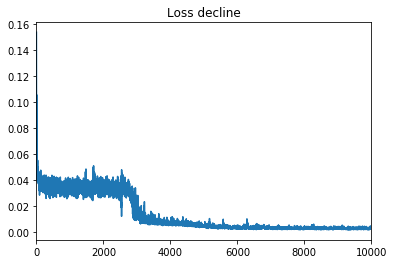

In [9]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized
Finished


In [12]:
# choose threshold
min_a = min(abnormal_score)
normal_score = np.array(normal_score)
foo = normal_score[normal_score<min_a]
threshold =( np.median(np.array(abnormal_score)) + np.median(np.array(normal_score)) )/2

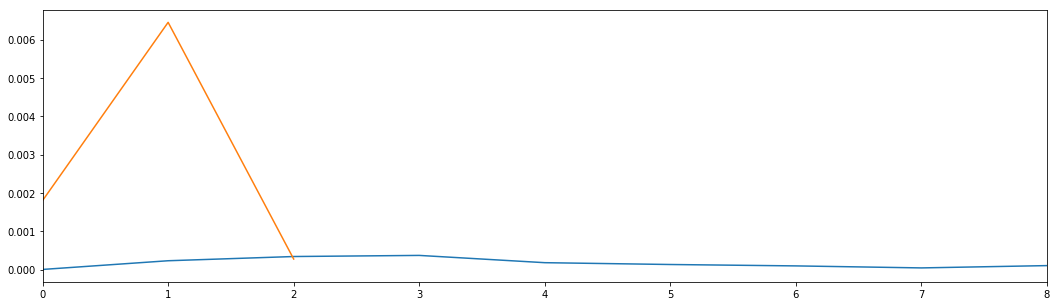

In [13]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v3.ckpt
Model restored.
Initialized


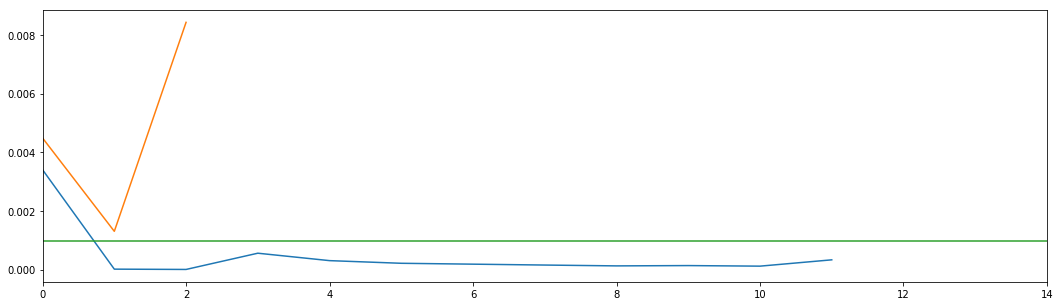

In [14]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

            
    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [15]:
beta = 0.1
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

0.9967105263157895

In [16]:
print(tp,fp,tn,fn,P,R)

3 0 11 1 1.0 0.75
